In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x:'%.3f' % x)
from pandas.tseries.offsets import *
from datetime import datetime, timedelta

C:\Users\YH817GQ\Anaconda3_new\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def plot_series(time,series,format='-'):
    plt.figure(figsize=(0,6)).set_figwidth(15)
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time,series_num,format)
    else:
        plt.plot(time,series,format)
    
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show

In [4]:
def train_test_split(data):
    size = int(len(data)*0.8)
    x_train = data.drop(columns=['close']).iloc[:size]
    x_test = data.drop(columns=['close']).iloc[size:]
    y_train = data['close'].iloc[:size]
    y_test = data['close'].iloc[size:]
    return x_train,x_test,y_train,y_test



def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols,names = list(),list()
    for i in range(n_in,0,-1):
        cols.append(df_temp.shift(i))
        names+=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0,n_out):
        cols.append(df_temp.shift(-1))
        if i==0:
            names+=[('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_data(train,test):
    reframed_train = series_to_supervised(train,1,1)
    reframed_test = series_to_supervised(test,1,1)
    
    train = reframed_train.values
    test = reframed_test.values
    
    train_X,y_train = train[:,:-1],train[:,-1]
    test_X,y_test = test[:,:-1], test[:,-1]
    
    x_train = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
    return x_train,x_test,y_train,y_test




In [30]:
df = pd.read_excel('sbi.xlsx')

df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.dayofweek+1
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

df = pd.get_dummies(df,columns=['weekday','month','quarter'])
# df.drop(columns=['Open', 'High', 'Low', 'Adj Close'],axis=1,inplace=True)
df = df[~df.isna()]
df = df.sort_values('date')
df.head()

,date,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2018-01-01,307.100,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2018-01-02,303.250,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2018-01-03,302.850,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2018-01-04,308.500,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2018-01-05,306.350,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


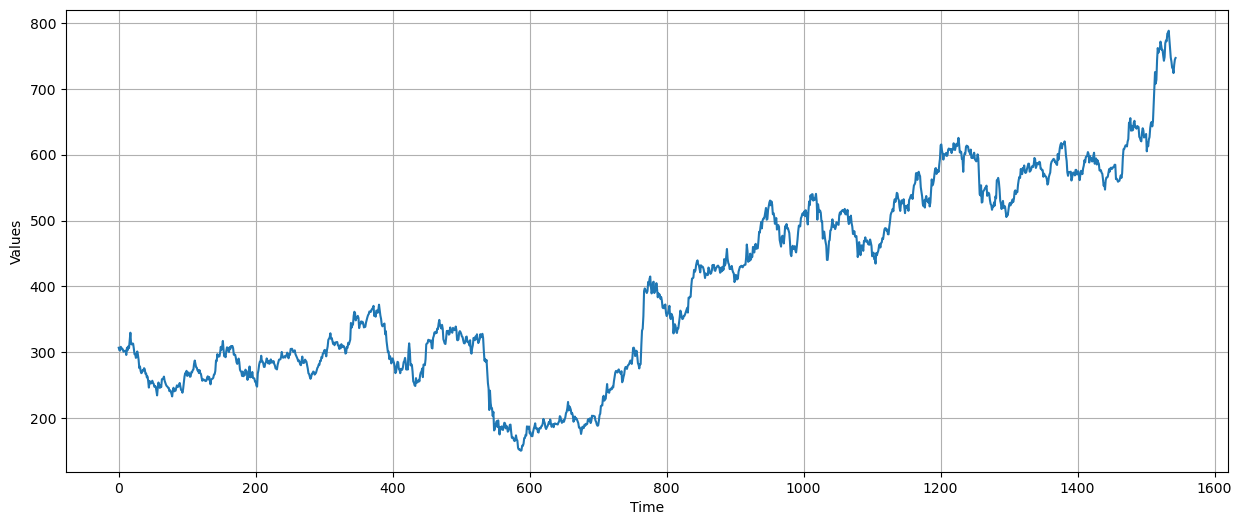

In [31]:
time = np.arange(len(df['close']))
series = df['close']
plot_series(time,series)

In [32]:
df.head()

,date,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2018-01-01,307.100,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2018-01-02,303.250,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2018-01-03,302.850,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2018-01-04,308.500,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2018-01-05,306.350,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [33]:
df = df.set_index('date')
df.head(10)

,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,307.100,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-02,303.250,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-03,302.850,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-04,308.500,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-05,306.350,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-08,305.800,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-09,304.300,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-10,301.100,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-11,302.200,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [34]:
df.columns

Index(['close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4'],
      dtype='object')

In [125]:
df1 = series_to_supervised(df[['close']],14,3).merge(df,how='left',on='date')
df1.head()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-19,307.100,303.250,302.850,308.500,306.350,305.800,304.300,301.100,302.200,302.250,302.600,296.150,307.100,303.250,306.500,306.500,306.500,309.250,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-22,303.250,302.850,308.500,306.350,305.800,304.300,301.100,302.200,302.250,302.600,296.150,307.100,303.250,309.250,318.100,318.100,318.100,306.500,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-23,302.850,308.500,306.350,305.800,304.300,301.100,302.200,302.250,302.600,296.150,307.100,303.250,309.250,306.500,329.900,329.900,329.900,318.100,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-24,308.500,306.350,305.800,304.300,301.100,302.200,302.250,302.600,296.150,307.100,303.250,309.250,306.500,318.100,313.150,313.150,313.150,329.900,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-25,306.350,305.800,304.300,301.100,302.200,302.250,302.600,296.150,307.100,303.250,309.250,306.500,318.100,329.900,312.100,312.100,312.100,313.150,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [126]:
df1.columns

Index(['var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)',
       'var1(t+1)', 'var1(t+2)', 'close', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [127]:
len(df1.columns)

41

In [171]:
df1 = df1[['var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'close', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'var1(t)',
       'var1(t+1)', 'var1(t+2)']]
df1.head()

KeyError: "['var1(t)', 'var1(t+1)', 'var1(t+2)'] not in index"

In [172]:
df_X,df_Y = df1.values[:,:-3],df1.values[:,-3:]

In [173]:
df_X


array([[773.3 , 772.05, 783.95, 783.9 , 788.05, 773.7 , 759.7 , 747.25,
        741.05, 731.9 , 730.95, 723.8 , 736.25, 744.3 , 746.7 ,   0.  ,
          0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   1.  ]])

In [131]:
df_Y

array([[306.5 , 306.5 , 306.5 ],
       [318.1 , 318.1 , 318.1 ],
       [329.9 , 329.9 , 329.9 ],
       ...,
       [736.25, 736.25, 736.25],
       [744.3 , 744.3 , 744.3 ],
       [746.7 , 746.7 , 746.7 ]])

In [132]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])
Y = df_Y

In [133]:
X.shape,Y.shape

((1529, 1, 38), (1529, 3))

In [134]:
X

array([[[307.1 , 303.25, 302.85, ...,   0.  ,   0.  ,   0.  ]],

       [[303.25, 302.85, 308.5 , ...,   0.  ,   0.  ,   0.  ]],

       [[302.85, 308.5 , 306.35, ...,   0.  ,   0.  ,   0.  ]],

       ...,

       [[742.5 , 748.1 , 769.15, ...,   0.  ,   0.  ,   0.  ]],

       [[748.1 , 769.15, 773.3 , ...,   0.  ,   0.  ,   0.  ]],

       [[769.15, 773.3 , 772.05, ...,   0.  ,   0.  ,   0.  ]]])

In [135]:
Y

array([[306.5 , 306.5 , 306.5 ],
       [318.1 , 318.1 , 318.1 ],
       [329.9 , 329.9 , 329.9 ],
       ...,
       [736.25, 736.25, 736.25],
       [744.3 , 744.3 , 744.3 ],
       [746.7 , 746.7 , 746.7 ]])

In [136]:
size = int(len(X)*0.8)
x_train = X[:size]
y_train = Y[:size]

x_test = X[size:]
y_test = Y[size:]

In [137]:
x_train.shape,y_train.shape

((1223, 1, 38), (1223, 3))

In [138]:
x_test.shape,y_test.shape

((306, 1, 38), (306, 3))

In [139]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(3))
model.compile(loss='mae',optimizer='adam')
history = model.fit(x_train,y_train,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
25/25 [==============================] - 2s 3ms/step - loss: 155.8843
Epoch 2/30
25/25 [==============================] - 0s 3ms/step - loss: 14.4970
Epoch 3/30
25/25 [==============================] - 0s 3ms/step - loss: 12.9040
Epoch 4/30
25/25 [==============================] - 0s 3ms/step - loss: 14.3388
Epoch 5/30
25/25 [==============================] - 0s 3ms/step - loss: 16.1773
Epoch 6/30
25/25 [==============================] - 0s 4ms/step - loss: 15.0740
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 15.9214
Epoch 8/30
25/25 [==============================] - 0s 3ms/step - loss: 14.7422
Epoch 9/30
25/25 [==============================] - 0s 4ms/step - loss: 16.9237
Epoch 10/30
25/25 [==============================] - 0s 4ms/step - loss: 16.4505
Epoch 11/30
25/25 [==============================] - 0s 4ms/step - loss: 14.7169
Epoch 12/30
25/25 [==============================] - 0s 4ms/step - loss: 13.5556
Epoch 13/30
25/25 [=================

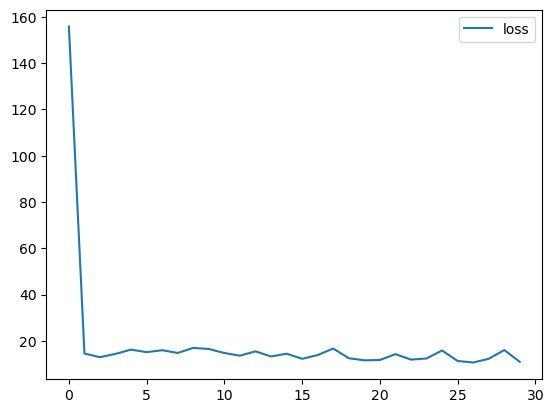

In [140]:
# Plot loss history
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.show()

In [141]:
y_test_pre = model.predict(x_test)
y_test_pre.shape,y_test.shape

10/10 [==============================] - 0s 2ms/step


((306, 3), (306, 3))

In [142]:
y_test_pre.shape

(306, 3)

In [143]:
y_test.shape

(306, 3)

In [144]:
len(list(pd.DataFrame(y_test).iloc[1:,0]))

305

In [145]:
len(list(pd.DataFrame(y_test_pre).iloc[:-1,0]))

305

In [148]:
# Make predictions
pred = pd.DataFrame()
pred['date'] = df1.reset_index()['date'][size:]
pred['predicted_close'] = list(pd.DataFrame(y_test_pre).iloc[:,0])
pred['actual_close'] = list(df1['var1(t-1)'][size:])
pred.head()

,date,predicted_close,actual_close
1223,2022-12-29,607.263,601.050
1224,2022-12-30,609.033,611.800
1225,2023-01-02,609.928,613.700
1226,2023-01-03,612.464,612.200
1227,2023-01-04,612.543,612.400


1.488587858104181

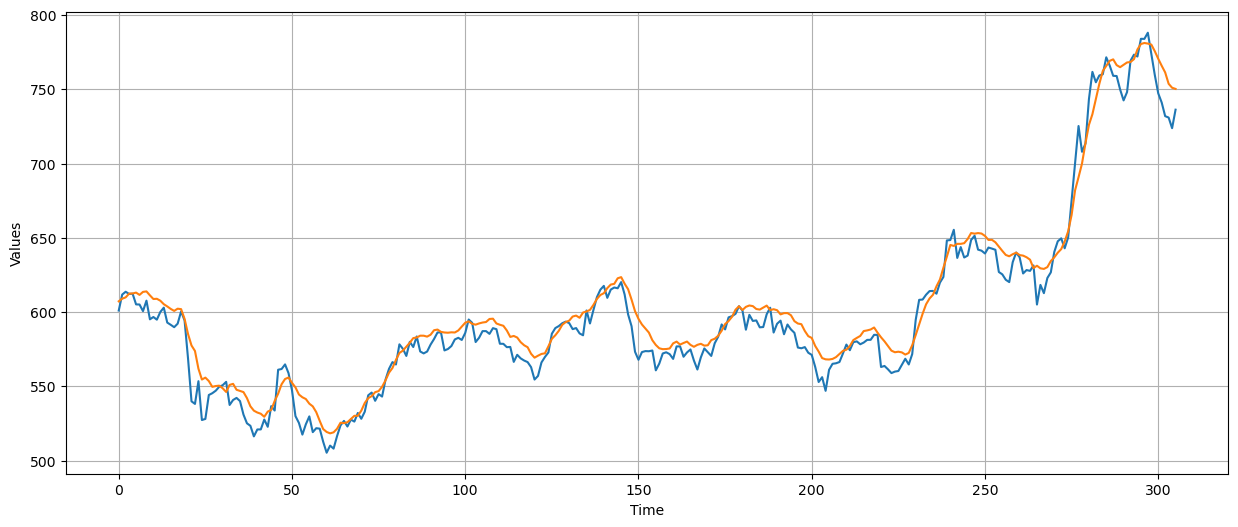

In [149]:
def measure_mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

time = np.arange(len(pred))
series1 = pred['actual_close']
series2 = pred['predicted_close']
plot_series(time,(series1,series2))
display(measure_mape(series1,series2))

In [31]:
## oot forecasting

In [150]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(3))
model.compile(loss='mae',optimizer='adam')
history = model.fit(X,Y,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
31/31 [==============================] - 2s 4ms/step - loss: 104.8464
Epoch 2/30
31/31 [==============================] - 0s 3ms/step - loss: 15.9735
Epoch 3/30
31/31 [==============================] - 0s 3ms/step - loss: 16.4761
Epoch 4/30
31/31 [==============================] - 0s 3ms/step - loss: 14.2362
Epoch 5/30
31/31 [==============================] - 0s 4ms/step - loss: 12.8709
Epoch 6/30
31/31 [==============================] - 0s 5ms/step - loss: 12.4342
Epoch 7/30
31/31 [==============================] - 0s 4ms/step - loss: 11.9201
Epoch 8/30
31/31 [==============================] - 0s 5ms/step - loss: 11.4616
Epoch 9/30
31/31 [==============================] - 0s 5ms/step - loss: 11.2130
Epoch 10/30
31/31 [==============================] - 0s 4ms/step - loss: 10.8067
Epoch 11/30
31/31 [==============================] - 0s 5ms/step - loss: 10.8910
Epoch 12/30
31/31 [==============================] - 0s 4ms/step - loss: 10.7227
Epoch 13/30
31/31 [=================

In [156]:
df1 = series_to_supervised(df[['close']].tail(15),14,0).merge(df,how='left',on='date')
df1

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,773.300,772.050,783.950,783.900,788.050,773.700,759.700,747.250,741.050,731.900,730.950,723.800,736.250,744.300,746.700,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [157]:
len(df1.columns)

38

In [159]:
df1 = df1[['var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'close', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']]
df1.head()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,773.300,772.050,783.950,783.900,788.050,773.700,759.700,747.250,741.050,731.900,730.950,723.800,736.250,744.300,746.700,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [170]:
df1.tail()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,773.300,772.050,783.950,783.900,788.050,773.700,759.700,747.250,741.050,731.900,730.950,723.800,736.250,744.300,746.700,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [160]:
df_X = df1.values[:,:]

In [161]:
df_X.shape

(1, 38)

In [162]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])

In [163]:
X.shape

(1, 1, 38)

In [164]:
X

array([[[773.3 , 772.05, 783.95, 783.9 , 788.05, 773.7 , 759.7 , 747.25,
         741.05, 731.9 , 730.95, 723.8 , 736.25, 744.3 , 746.7 ,   0.  ,
           0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ]]])

In [167]:
d = pd.DataFrame()
# d['eod_date'] = pd.bdate_range(start=pd.to_datetime('2024-03-25'),end=pd.to_datetime('2024-03-25')+pd.DateOffset(3))
d['forecast'] = model.predict(X)[0]

1/1 [==============================] - 0s 31ms/step


In [168]:
d

,forecast
0,750.805
1,750.892
2,751.450


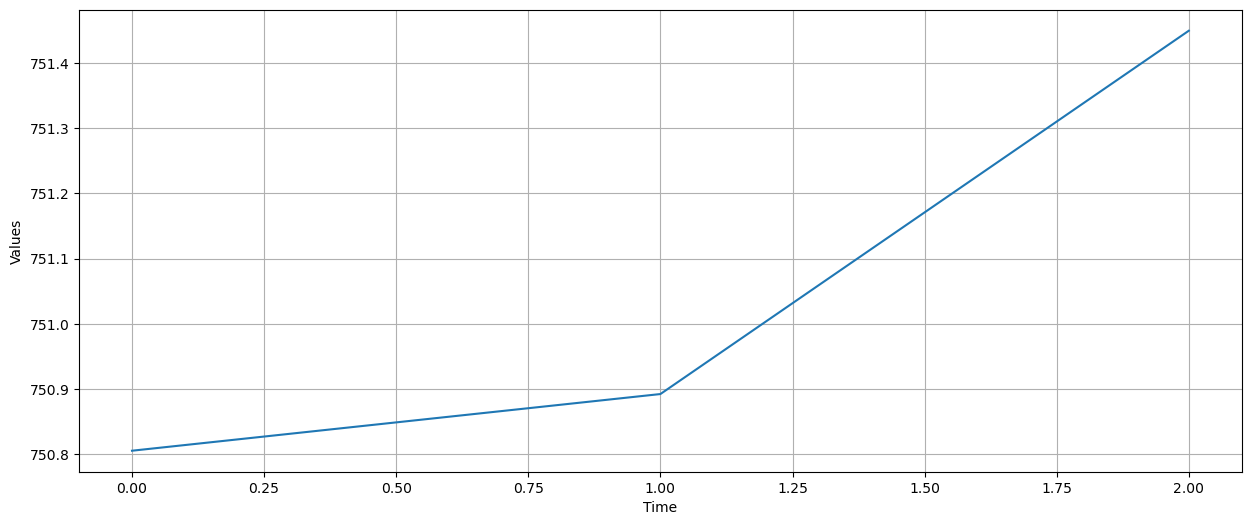

In [169]:
time = np.arange(len(d))
series1 = d['forecast']
# series2 = pred['predicted_close']
plot_series(time,(series1))
# display(measure_mape(series1,series2))